In [1]:
%load_ext autoreload
%autoreload 2

In [180]:
import os
import numpy as np
import json
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import webcolors

from minimal.imaging import draw_plan
from minimal.layout import LayoutGraph, NodeType, NODE_COLOR, NODE_NAME
from minimal.gen import generate_plan

%matplotlib inline

In [222]:
g_node_idx = 0

class Node:
    idx: int
    type: int

    def __init__(self, type: int):
        global g_node_idx

        self.idx = g_node_idx
        self.type = type

        g_node_idx += 1

    @property
    def color(self):
        return NODE_COLOR[self.type]

    @property
    def name(self):
        return NODE_NAME[self.type]

    def __str__(self):
        return f"Node({self.name})"

    def __repr__(self):
        return str(self)
    
    def __hash__(self):
        return hash(self.idx)

    def __eq__(self, other):
        return isinstance(other, Node) and self.idx == other.idx

In [250]:
g_node_idx = 0

G = nx.Graph()

fr = Node(NodeType.FRONT_DOOR)
G.add_node(fr)
liv = Node(NodeType.LIVING_ROOM)
G.add_node(liv)

kit = Node(NodeType.KITCHEN)
G.add_node(kit)
bal = Node(NodeType.BALCONY)
G.add_node(bal)

r1 = Node(NodeType.BEDROOM)
G.add_node(r1)
b1 = Node(NodeType.BATHROOM)
G.add_node(b1)

r2 = Node(NodeType.BEDROOM)
G.add_node(r2)
b2 = Node(NodeType.BATHROOM)
G.add_node(b2)

r3 = Node(NodeType.BEDROOM)
G.add_node(r3)
b3 = Node(NodeType.BATHROOM)
G.add_node(b3)

G.add_edge(liv, fr)
G.add_edge(liv, kit)
G.add_edge(liv, r1)
G.add_edge(liv, r2)
G.add_edge(liv, r3)

G.add_edge(r1, b1)
G.add_edge(r2, b2)
G.add_edge(r3, b3)
G.add_edge(r3, bal)

door_edges = []

for (a, b) in G.edges:
    if NodeType.is_room(a.type) and NodeType.is_room(b.type):
        door_edges.append((a, b))

for (a, b) in door_edges:
    door = Node(NodeType.INTERIOR_DOOR)
    G.add_node(door)
    G.add_edge(a, door)
    G.add_edge(b, door)

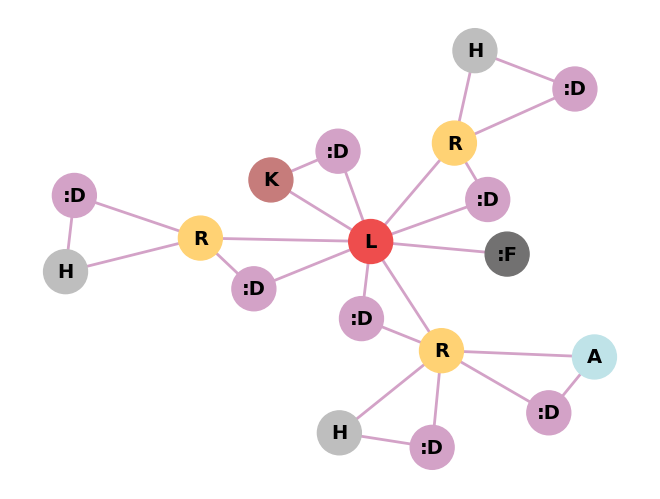

In [251]:
def nodelist(G, func):
    return [func(node) for node in G.nodes]

def nodedict(G, func):
    return { node: func(node) for node in G.nodes }

nx.draw(
    G,
    nx.kamada_kawai_layout(G),
    node_size=1000,
    node_color=nodelist(G, lambda n: n.color),
    edge_color="#D3A2C7",
    font_color="black",
    font_weight="bold",
    font_size=14,
    width=2.0,
    with_labels=True,
    labels=nodedict(G, lambda n: n.name)
)